# QF 627 Programming and Computational Finance
### Lesson 08 | Unsupervised Learning, Clustering, and Pairs Trading

> Hi, Team 👋 

> Last week we learned how to use an unsupervised learning framework of dimensionality reduction (in particular, PCA) to solve an asset allocation and portfolio management problem. This week we will continue to see how useful clustering can be for common questions in quantitative finance.

> We will start with a quick lesson on how k-means clustering is operated. This will give you an initial understanding of clustering algorithms. We will then use clustering for paired trading. After our discussion leading session, we will continue to see how to use clustering to identify support and resistance levels.

### Activation of necessary modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas_datareader as dr
from pandas_datareader import data as pdr

import datetime
import yfinance as yf

import warnings

#### Setting plotting and display options

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

warnings.filterwarnings("ignore")

    PROBLEM STATEMENT
    
> Our goal in this case study is to perform clustering analysis on S&P500 stocks, and to come up with pairs, for a pairs trading strategy.

> The stocks data are obtained using pandas_datareader from Yahoo Finance. It includes price data from January 2008 to October 11th of 2019.

## Pairs Trading Using Clustering

> Pairs trading with clustering is an advanced market-neutral strategy that leverages data-driven techniques to identify tradable pairs. Let's dive deeper into its rationale and execution:

### Basic Pairs Trading

> Pairs trading is a market-neutral trading strategy designed to exploit anomalies between two or more securities.

> The foundational idea is:

- If two stocks historically move in tandem and suddenly diverge, they're expected to revert to their historical norm.
- Strategy: Short the outperforming stock and buy the underperforming one.

### Why Use Clustering?

Identifying which pairs of stocks move congruently is a challenge. This is where clustering offers its utility.

### What is Clustering?

Clustering is an unsupervised machine learning technique that groups similar items:

- For stocks, it means clustering them based on similar price movements.
- Stocks within the same cluster are anticipated to have similar movements.

### Benefits of Clustering in Pairs Trading

- **Identification of Pairs**: Automates the process of finding stocks that move similarly.
- **Dynamic Adaptation**: Allows traders to adapt to changing market dynamics by periodically re-running the clustering algorithm.
- **Diversification**: Identifies multiple pairs across clusters, diversifying the trading strategy.
- **Risk Management**: Diversified pairs trading can cushion against sector-specific downturns.

### Oft-used Clustering Techniques

- **K-Means Clustering**: Partitions data into \( K \) distinct, non-overlapping clusters.
- **Hierarchical Clustering**: Constructs a tree of clusters, suitable for nested relationships.
- **DBSCAN**: Ideal for clusters of varying shapes.

### Workflow of Pairs Trading

    Step 1. Choose a historical window of stock price data.
    Step 2. Compute returns (and volatility) for each stock.
    Step 3. Apply a clustering algorithm based on these returns (and volatilities).
    Step 4. Identify tradable pairs or groups within each cluster.
    Step 5. Monitor pairs for deviations and trade based on historical norms.

### Towards Data-driven Trading Strategy Building

> Pairs trading using clustering is a methodical, data-centric approach to pinpoint and capitalize on price discrepancies between securities. Clustering algorithms unveil latent relationships in the data and acclimatize to evolving market conditions.


### Load Packages for ML

In [3]:
import pandas as pd
from pandas import read_csv, set_option

In [4]:
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

In [6]:
import matplotlib.ticker as ticker
from itertools import cycle

### Step 1: IMPORT

In [7]:
dataset = read_csv("sp500.csv", 
                   index_col =0)

In [8]:
type(dataset)

pandas.core.frame.DataFrame

### Step 2: Data Wrangling and Exploratory Data Analysis

#### Descriptive Statistics

In [9]:
dataset.shape

(448, 502)

In [10]:
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


In [11]:
dataset.tail(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-07,81.040001,74.330002,164.429993,186.809998,55.410000,276.899994,28.930000,158.270004,15.85,74.830002,...,187.589996,107.019997,64.279999,29.830000,92.629997,75.570000,113.690002,134.500000,43.439999,126.070000
2019-10-08,78.510002,73.529999,159.490005,182.199997,54.130001,270.829987,28.230000,154.330002,15.51,71.800003,...,184.360001,102.570000,63.590000,28.309999,89.269997,73.430000,112.589996,131.220001,42.209999,125.379997
2019-10-09,79.500000,73.300003,159.309998,184.339996,53.430000,274.269989,28.459999,154.410004,15.54,72.250000,...,186.199997,104.419998,63.919998,28.760000,90.480003,74.570000,113.330002,133.419998,42.419998,126.430000
2019-10-10,80.139999,74.449997,162.339996,183.830002,53.689999,274.980011,28.379999,155.949997,15.82,73.059998,...,187.690002,106.059998,63.950001,28.820000,92.809998,75.430000,114.330002,134.070007,43.209999,127.410004
2019-10-11,79.629997,73.629997,169.639999,184.970001,54.820000,278.290009,29.750000,158.559998,16.01,75.970001,...,188.100006,112.779999,63.330002,29.410000,96.220001,77.629997,114.449997,136.440002,44.090000,128.470001


In [12]:
dataset.describe()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,...,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,70.934196,88.078013,307.303839,167.473750,59.630804,252.270603,21.804754,147.501428,14.534888,128.423750,...,165.139486,139.475335,51.671027,29.151071,90.774487,74.549040,93.492455,120.406161,49.230245,94.787232
std,9.015754,13.480891,71.989893,14.635497,13.119012,29.001055,7.425020,21.095302,2.266254,38.573308,...,17.383970,29.251895,6.650626,3.450413,21.081242,4.926937,11.958700,9.199975,4.820335,14.395919
min,56.270000,62.980000,159.309998,133.669998,40.110001,177.699997,9.530000,103.760002,10.060000,71.800003,...,134.839996,92.010002,42.130001,18.920000,62.820000,61.380001,76.300003,97.230003,38.509998,71.510002
25%,62.620001,78.657503,260.557487,157.280006,47.037500,235.377495,15.147500,133.307499,12.847500,94.059998,...,151.705002,114.085001,45.689999,27.139999,71.664999,70.547503,83.507502,114.030001,45.107500,84.557499
50%,70.014999,88.524998,301.940002,162.880005,55.269999,254.684998,21.885000,154.949997,14.830000,113.389999,...,158.809998,132.974998,49.370001,29.075000,85.195000,75.165001,89.930000,120.645000,49.184999,90.090000
75%,78.620003,96.667498,368.095001,178.337502,71.565002,272.989990,28.437500,163.614998,16.355000,158.855000,...,178.064999,164.927498,56.715001,31.455000,109.367500,78.359999,101.462500,125.850002,53.214999,101.970001
max,88.739998,123.209999,449.750000,201.119995,83.389999,311.269989,34.389999,184.720001,18.410000,215.759995,...,199.360001,201.509995,65.820000,36.480000,139.720001,84.410004,119.209999,142.610001,58.540001,128.470001


#### Data Visualization?

> We will take a detailed look into visualization after clustering.

#### Data Preparation

> `Data Cleaning`

> We check for the NAs in the rows, and either drop them or fill them with the mean of the column.

In [13]:
# Checking for any null values and removing missing values

print("Missing Values? =", 
      dataset
          .isnull()
          .values
          .any()
     )

Missing Values? = True


> Delete any columns where more than 30% of the values are missing.

In [14]:
missing_fractions = \
    dataset \
    .isnull() \
    .mean() \
    .sort_values(ascending = False)

In [15]:
missing_fractions.head(10)

CTVA    0.781250
DOW     0.678571
FOX     0.667411
FOXA    0.665179
NOV     0.000000
MSI     0.000000
MSCI    0.000000
MYL     0.000000
NDAQ    0.000000
ABT     0.000000
dtype: float64

In [16]:
drop_list =\
    sorted(list(missing_fractions
                [missing_fractions > 0.3]
                .index)
           )

In [17]:
dataset =\
    dataset \
    .drop(labels= drop_list, 
          axis=1)

In [18]:
dataset.shape[1] == 502 - 4

True

> As there are null values, drop the rows containing the null values.

In [19]:
# Fill the missing values with the last value available in the dataset. 

dataset = dataset.fillna(method = "ffill")
dataset.head()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


#### Data Transformation

> For the purpose of clustering, we will use annual returns and variance as the variables as they are indicators of a stock’s performance and its volatility. 

> Let us prepare the return and volatility variables from the data.

In [20]:
#Calculate average annual percentage return and volatilities over a theoretical one year period

returns =\
(
    dataset
    .pct_change()
    .mean() 
    * 252
)

returns = pd.DataFrame(returns)

returns.columns = ["Returns"]

In [21]:
returns["Volatility"] =\
(    
     dataset
    .pct_change()
    .std() 
    * np.sqrt(252)
)

data = returns

In [22]:
# You may format the data as a numpy array to feed into the K-Means algorithm

data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

> All the variables should be on the same scale before applying clustering. 

> Otherwise, a feature with large values will dominate the result. 

> We use `StandardScaler` in sklearn to standardize the dataset’s features onto a unit scale (mean = 0 and variance = 1).

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler().fit(data)

In [25]:
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = returns.columns, index = returns.index)
rescaledDataset.head()

,Returns,Volatility
ABT,0.794067,-0.702741
ABBV,-0.927603,0.794867
ABMD,-0.054463,2.796251
ACN,0.405155,-0.802003
ATVI,-0.409875,1.495648


In [26]:
# summarize transformed data
X = rescaledDataset
X.head()

,Returns,Volatility
ABT,0.794067,-0.702741
ABBV,-0.927603,0.794867
ABMD,-0.054463,2.796251
ACN,0.405155,-0.802003
ATVI,-0.409875,1.495648


> The parameters to the clusters are the indices, and the variables used in the clustering are the columns. So the data is in the right format to be fed to the clustering algorithms.

# Step 3: Model (with `Clustering`)

> We will look at the following models:

#### 1. KMeans
#### 2. Hierarchical Clustering (Agglomerative Clustering)
#### 3. Affinity Propagation 

### K-Means Clustering


#### Finding optimal number of clusters

In this step we look at the following metrices:

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

  File "E:\software\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "E:\software\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\software\anaconda3\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "E:\software\anaconda3\Lib\subprocess.py", line 1509, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


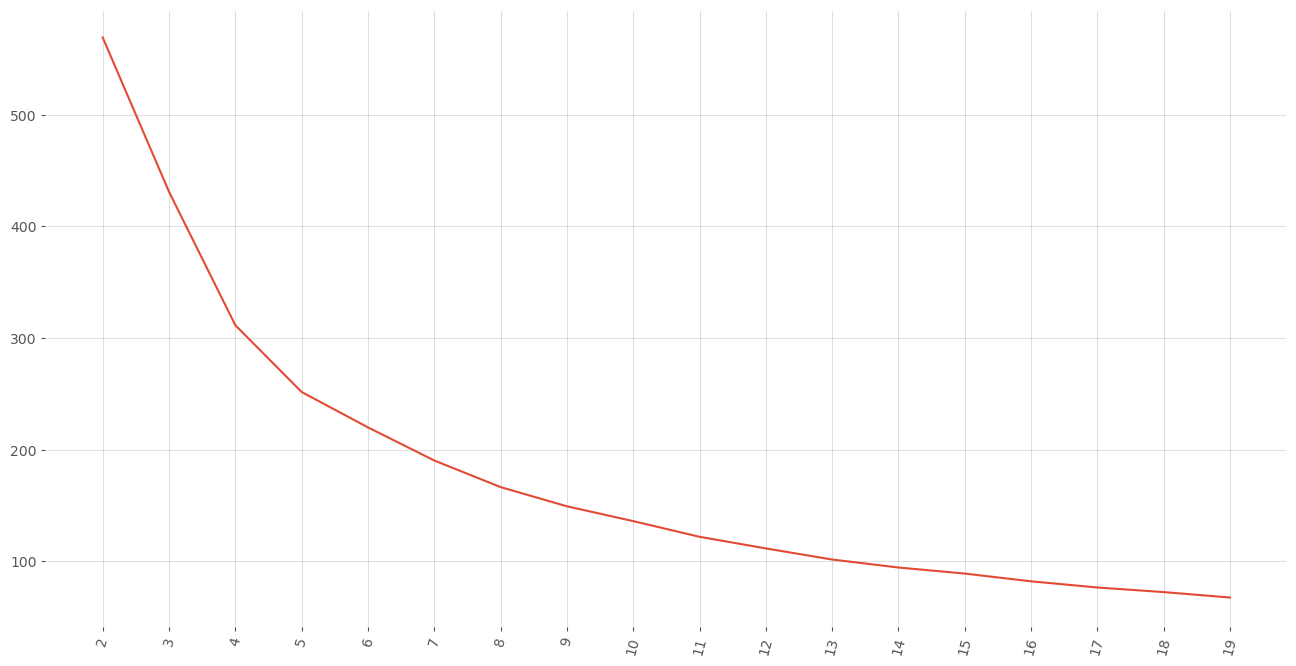

In [27]:
distorsions = []

max_loop = 20

for k in range(2, max_loop):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(16, 8))

plt.plot(range(2, max_loop), distorsions)

plt.xticks([i for i in range(2, max_loop)], 
           rotation=75)

plt.grid(True)

> Inspecting the sum of squared errors chart, it appears that the elbow `kink` occurs in five or six clusters for this data. 

> Certainly, we can see that as the number of clusters increases beyond six, the sum of the square of errors within clusters reaches a plateau.

#### Silhouette score

In [28]:
from sklearn import metrics

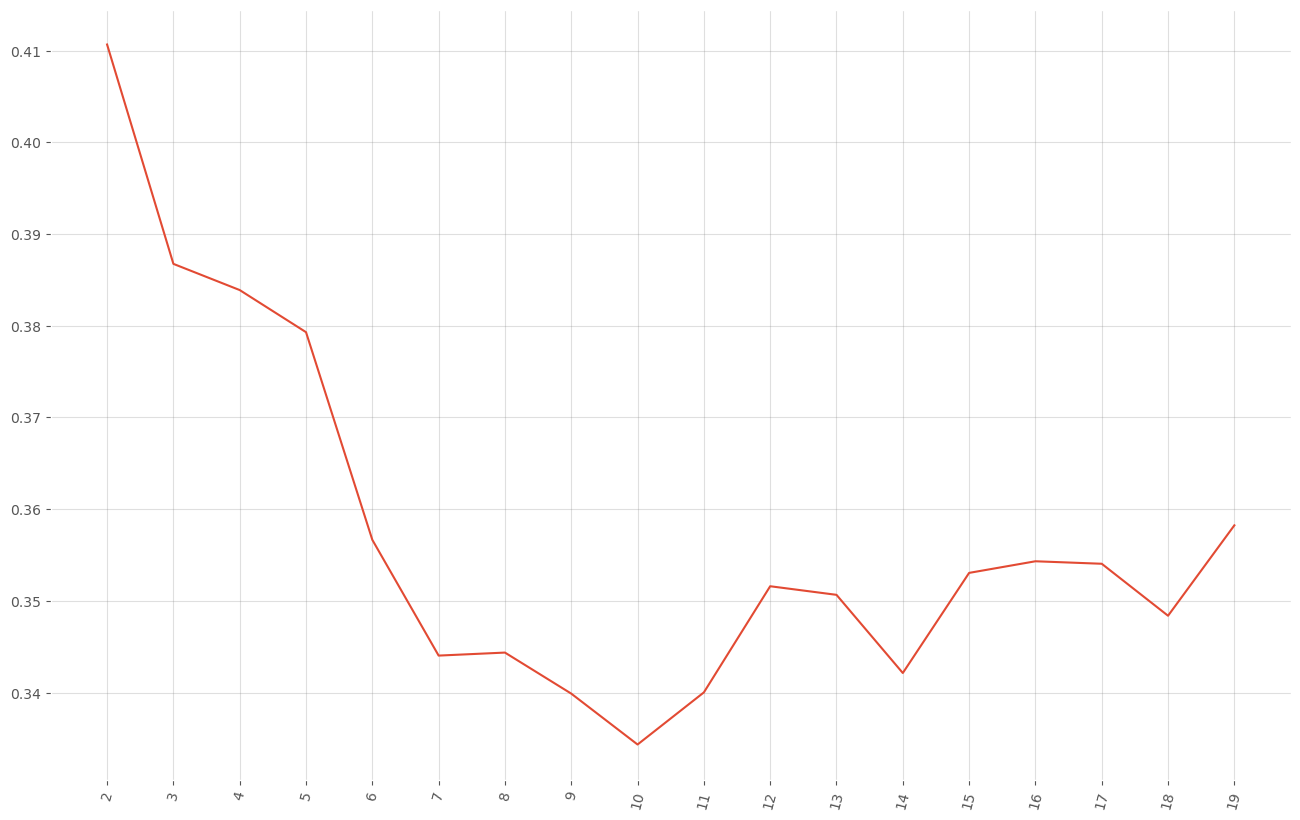

In [29]:
silhouette_score = []

for k in range(2, max_loop):
        kmeans = KMeans(n_clusters = k,  
                        random_state = 10, 
                        n_init = 10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10)
                               )
        
fig = plt.figure(figsize=(16, 10)
                )

plt.plot(range(2, max_loop), silhouette_score)

plt.xticks([i for i in range(2, max_loop)], 
           rotation=75)

plt.grid(True)

> On the silhouette score chart, there are various parts of the graph where a kink can be seen. Since there is not much difference in SSE after six clusters, we would prefer to have six clusters in the k-means model.

#### Clustering and Visualisation

> Let us build the k-means model with six clusters and visualize the results.

In [30]:
nclust = 6

In [31]:
# Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=6)

In [32]:
!pip install threadpoolctl==3.1.0

In [33]:
!pip install numpy==1.21.4

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0rc1, 1.23.0rc2, 1.23.0rc3, 1.2

In [34]:
import numpy as np

In [35]:
import threadpoolctl 

In [36]:
!pip install -U scikit-learn

In [37]:
import sklearn

print(sklearn.show_versions()
     )


System:
    python: 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
executable: E:\software\anaconda3\python.exe
   machine: Windows-10-10.0.19045-SP0

Python dependencies:
      sklearn: 1.3.2
          pip: 23.1.2
   setuptools: 67.8.0
        numpy: 1.24.3
        scipy: 1.10.1
       Cython: None
       pandas: 2.1.0
   matplotlib: 3.7.1
       joblib: 1.2.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: mkl
         prefix: mkl_rt
       filepath: E:\software\anaconda3\Library\bin\mkl_rt.2.dll
        version: 2023.1-Product
threading_layer: intel
    num_threads: 4

       user_api: openmp
   internal_api: openmp
         prefix: vcomp
       filepath: E:\software\anaconda3\Lib\site-packages\sklearn\.libs\vcomp140.dll
        version: None
    num_threads: 8
None


In [38]:
# Extracting labels 

target_labels = k_means.predict(X)

> Visualizing how your clusters are formed is not easy, when the number of variables or dimensions in your dataset is very large. 

> One of the methods of visualizing a cluster is two-dimensional space.

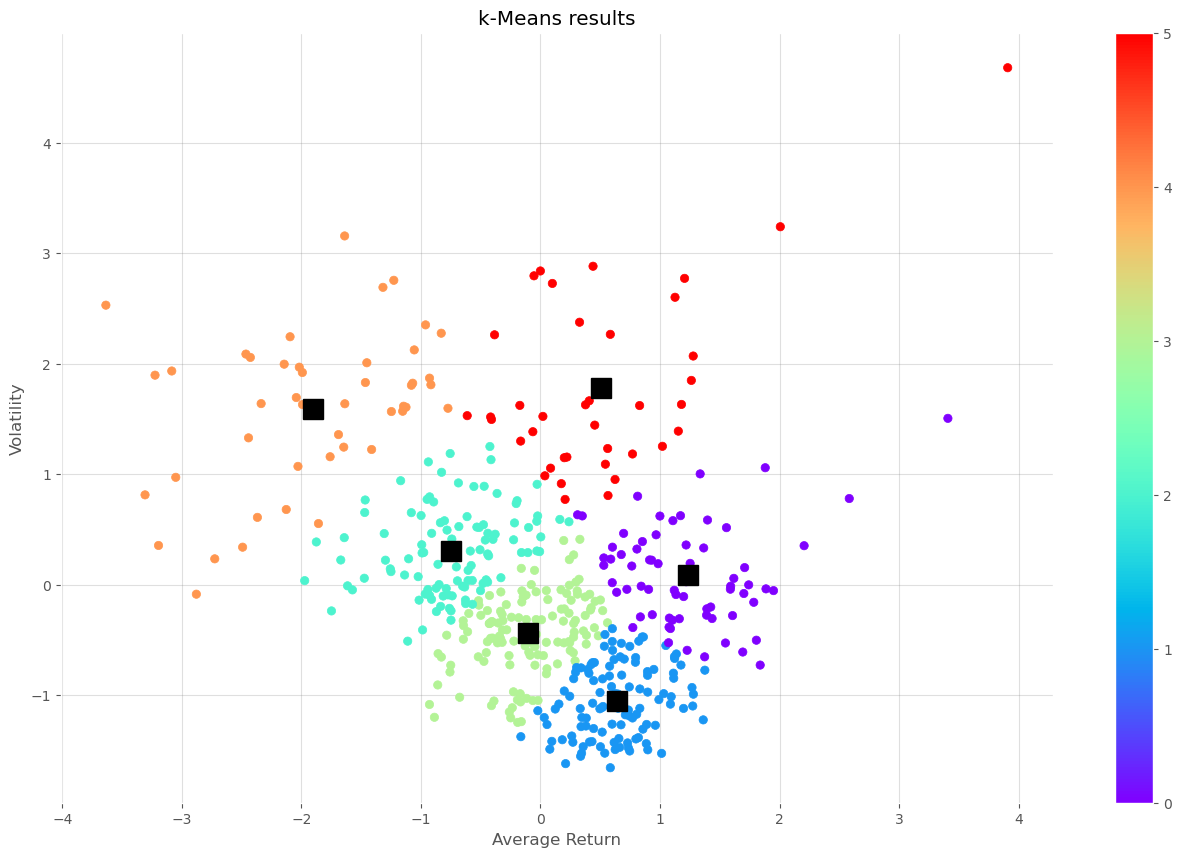

In [39]:
centroids = k_means.cluster_centers_

fig = plt.figure(figsize=(16,10)
                )

ax = fig.add_subplot(111)

scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c = k_means.labels_, cmap = "rainbow", label = X.index)

ax.set_title("k-Means results")
ax.set_xlabel("Average Return")
ax.set_ylabel("Volatility")

plt.colorbar(scatter)

plt.plot(centroids[:,0], centroids[:,1], 'sg', markersize=15, color = "black")

Let us check the elements of the clusters

In [40]:
# show number of stocks in each cluster

clustered_series =\
(
    pd
    .Series(index = X.index, 
            data = k_means
                   .labels_
                   .flatten()
            )
)

In [41]:
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten()
                                )

clustered_series = clustered_series[clustered_series != -1]

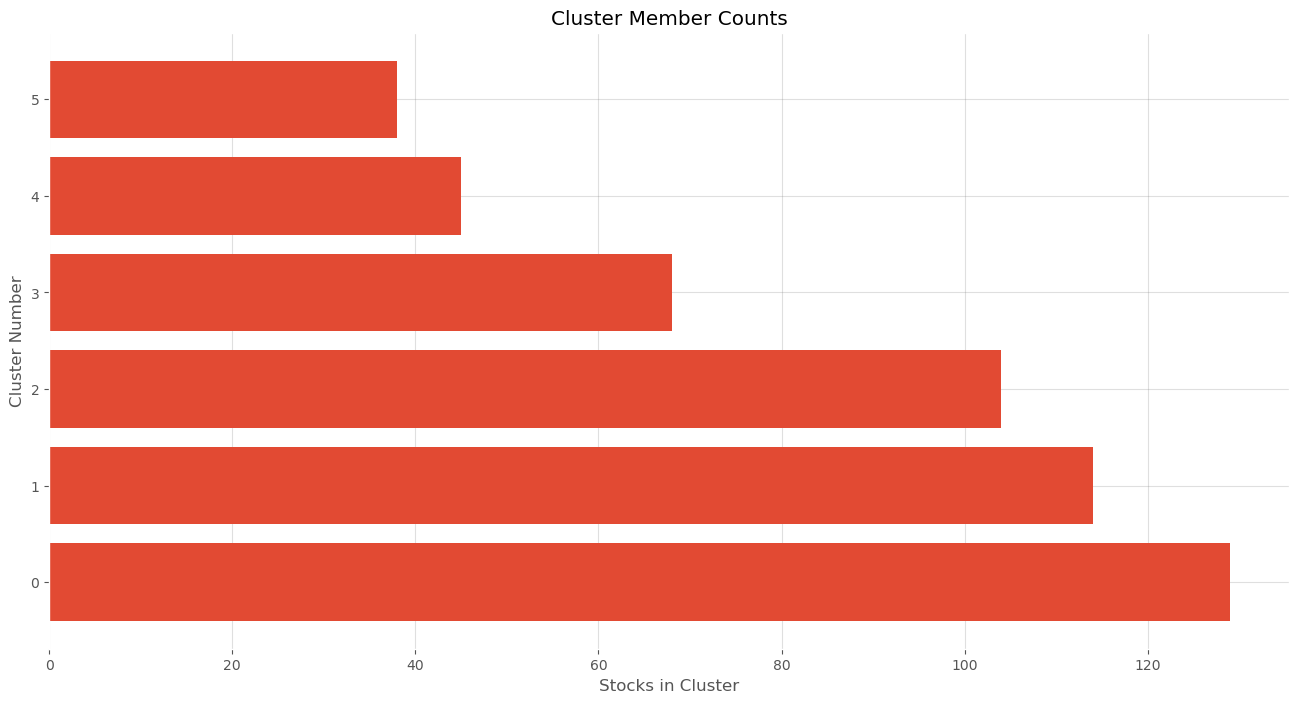

In [42]:
#here has some problems
plt.figure(figsize=(16,8)
          )

plt.barh(
    range(len(clustered_series.value_counts()
             )
         ), # cluster labels, y axis
    clustered_series.value_counts()
)

plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')

plt.show()

> The number of stocks in a cluster range from around 40 to 120. Although the distribution is not equal, we have an adequate number of stocks in each cluster.

### Hierarchical Clustering (Agglomerative Clustering)

> In the first step we look at the hierarchy graph and check for the number of clusters.

#### Building Hierarchy Graph/ Dendogram

> The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use “ward” as the method since it minimizes the variants of distances between the clusters.

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

In [44]:
#Calulate linkage
Z = linkage(X, 
            method = "ward")
Z[0]

array([3.300e+01, 3.140e+02, 3.626e-03, 2.000e+00])

> The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree. 

> The tree’s leaves are the individual stocks and the root is the final single cluster. 

> The `distance` between each cluster is shown on the y-axis; the longer the branches are, the less correlated two clusters are.

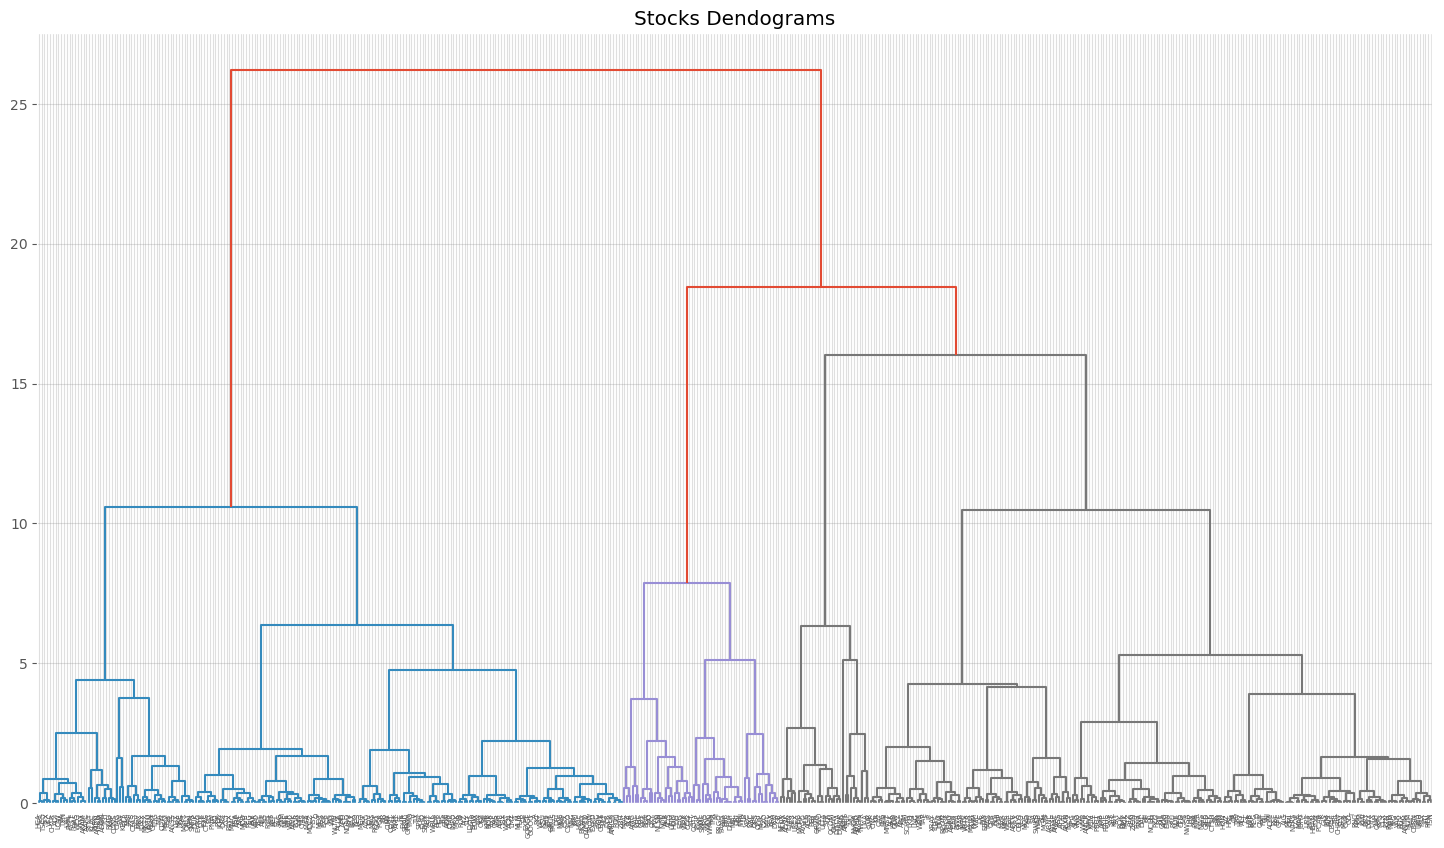

In [45]:
# Plot Dendogram

plt.figure(figsize=(18, 10)
          )
plt.title("Stocks Dendograms")

dendrogram(Z, labels = X.index)

plt.show()

> Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. 

> The number of vertical lines this newly created horizontal line passes is equal to the number of clusters.

In [46]:
distance_threshold = 13

clusters = fcluster(Z, distance_threshold, criterion='distance')

chosen_clusters = pd.DataFrame(data=clusters, 
                               columns=['cluster']
                              )

chosen_clusters['cluster'].unique()

array([1, 4, 3, 2])

> We then select the distance threshold to cut the dendrogram to obtain the selected clustering level. 

> The output is the cluster labeled for each row of data. 

> As expected from the dendrogram, a cut at 13 gives us four clusters.

#### Clustering and Visualisation

In [47]:
nclust = 4

hc = AgglomerativeClustering(n_clusters = nclust, 
                             affinity = "euclidean", 
                             linkage = "ward")

clust_labels1 = hc.fit_predict(X)

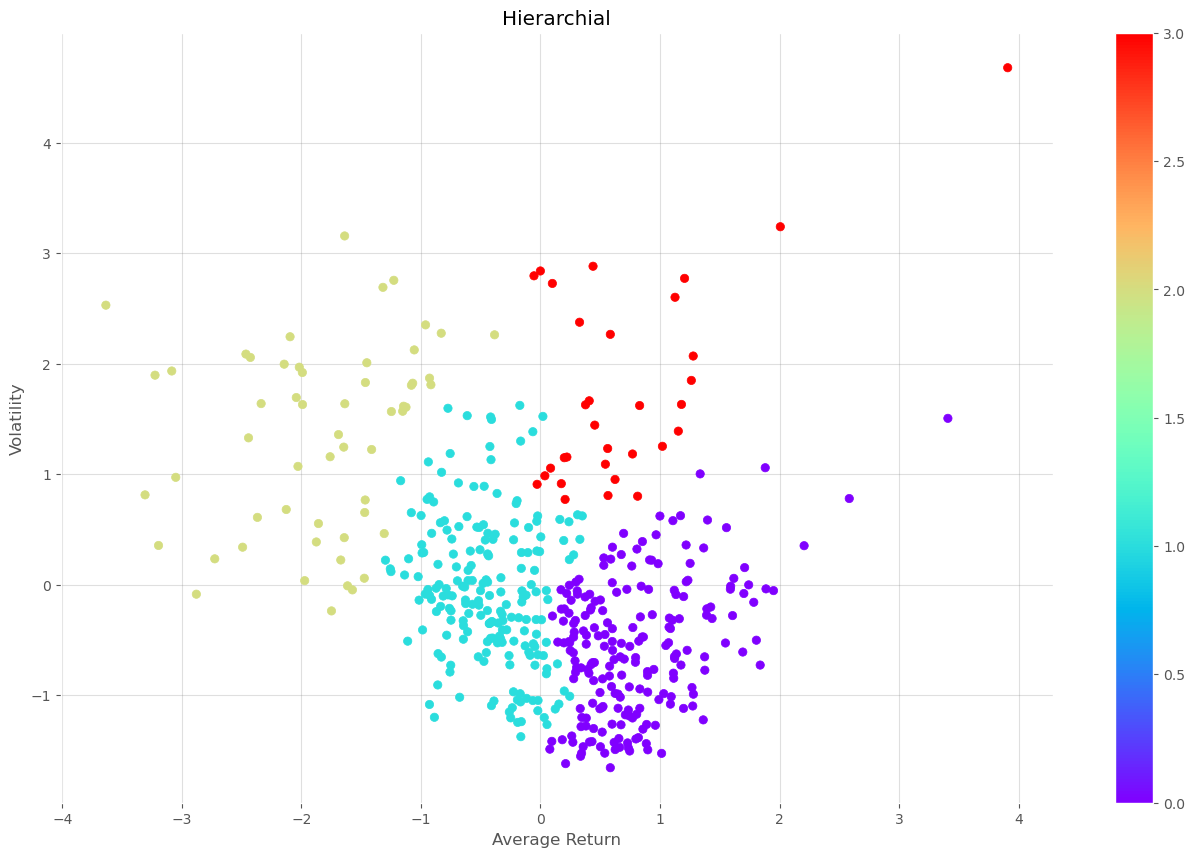

In [48]:
fig = plt.figure(figsize=(16,10)
                )

ax = fig.add_subplot(111)

scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c = clust_labels1, cmap = "rainbow")

ax.set_title("Hierarchial")
ax.set_xlabel("Average Return")
ax.set_ylabel("Volatility")

plt.colorbar(scatter)

> Similar to the plot of k-means clustering, we see that there are some distinct clusters
separated by different colors. 

### Affinity Propagation

In [49]:
ap = AffinityPropagation()

ap.fit(X)

clust_labels2 = ap.predict(X)

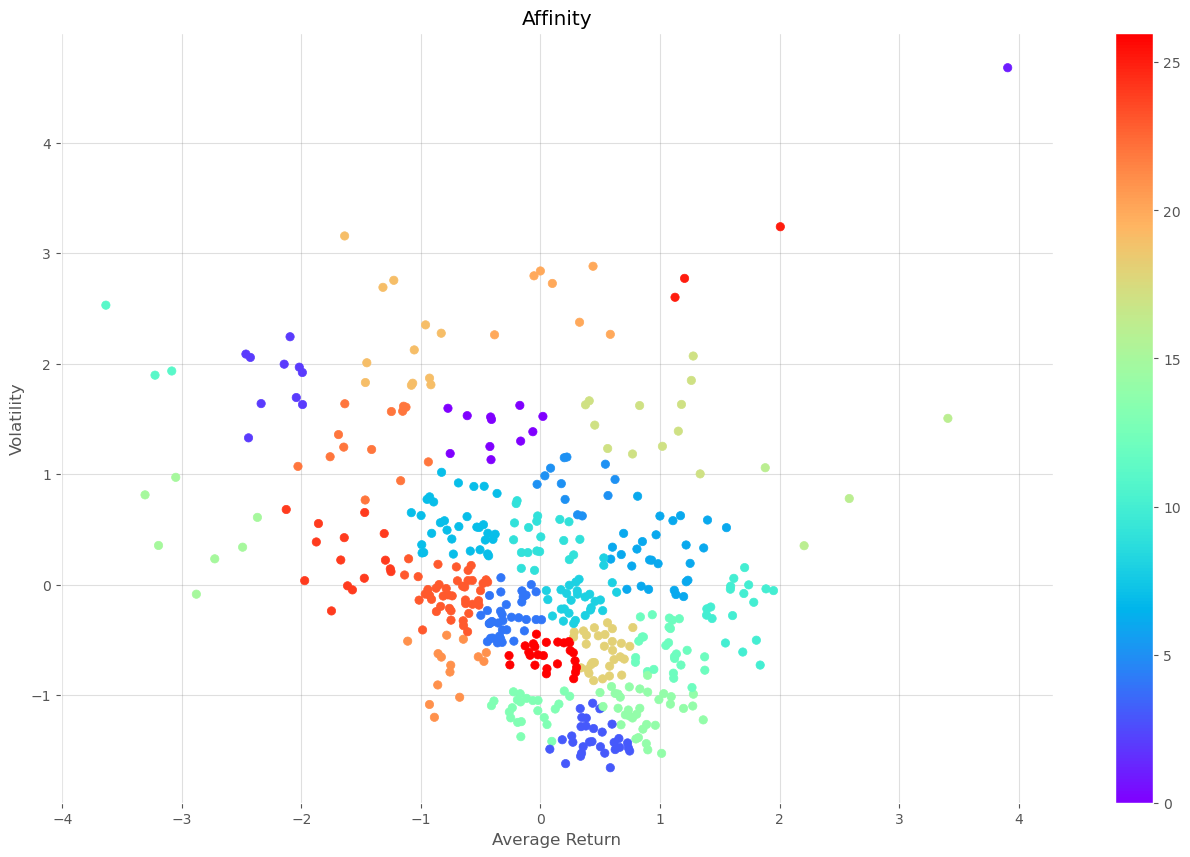

In [50]:
fig = plt.figure(figsize=(16,10)
                )
ax = fig.add_subplot(111)

scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c = clust_labels2, cmap = "rainbow")

ax.set_title("Affinity")
ax.set_xlabel("Average Return")
ax.set_ylabel("Volatility")
             
plt.colorbar(scatter)

Similar to the plot of k-means clustering, we see that there are some distinct clusters separated by different colors. 

<a id='5.3.1'></a>
### 5.3.1 Cluster Visualisation

In [51]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 27


<Figure size 640x480 with 0 Axes>

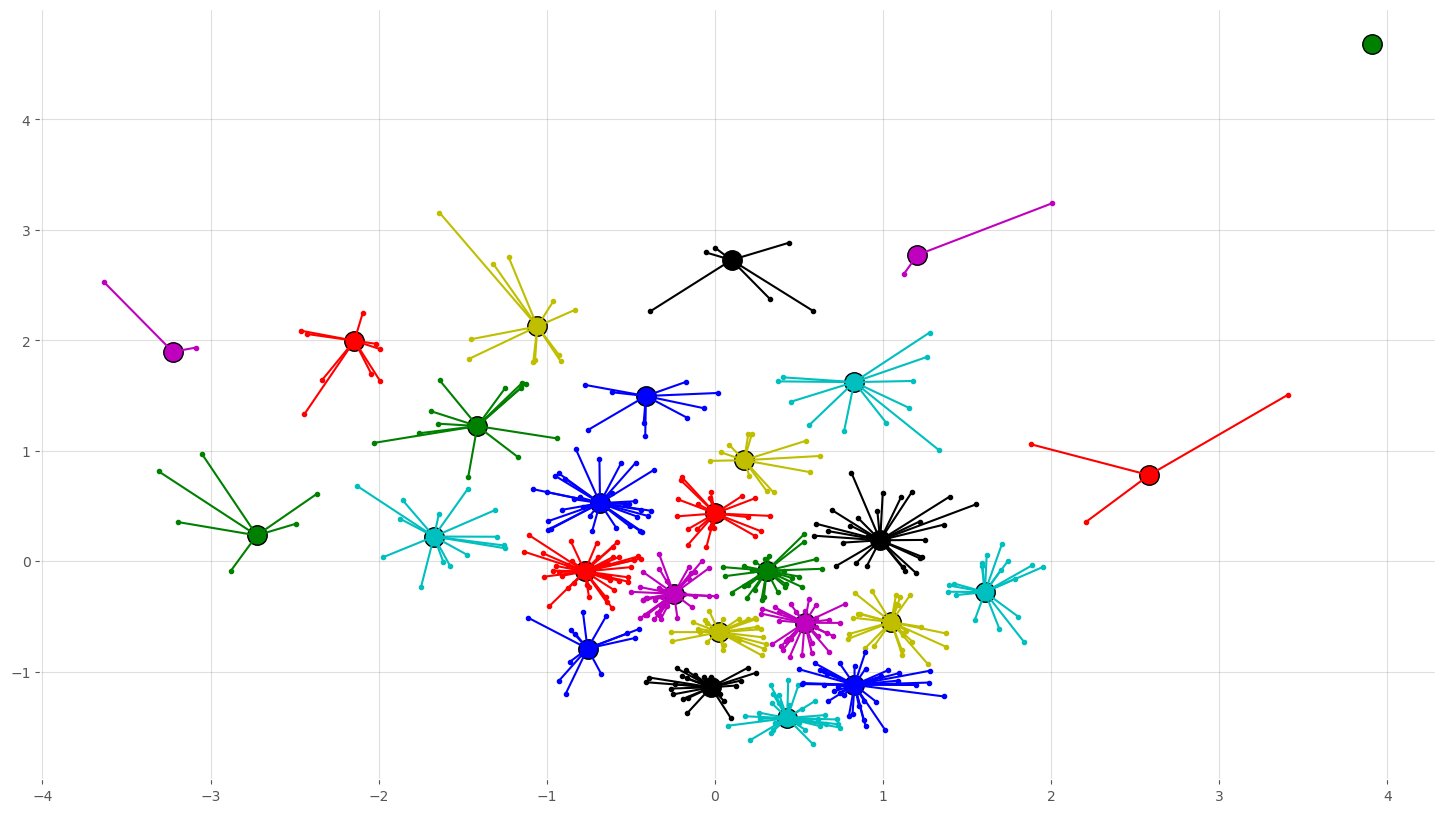

In [52]:
no_clusters = len(cluster_centers_indices)
print("Estimated number of clusters: %d" % no_clusters)

# Plot exemplars

X_temp=np.asarray(X)
plt.close("all")
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(18,10)
                )
colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

for k, col in zip(range(no_clusters), colors):
    
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + ".")
    
    plt.plot(cluster_center[0], cluster_center[1], 
             "o", 
             markerfacecolor = col, 
             markeredgecolor = "k", 
             markersize = 14)
    
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

In [53]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten()
                               )

# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

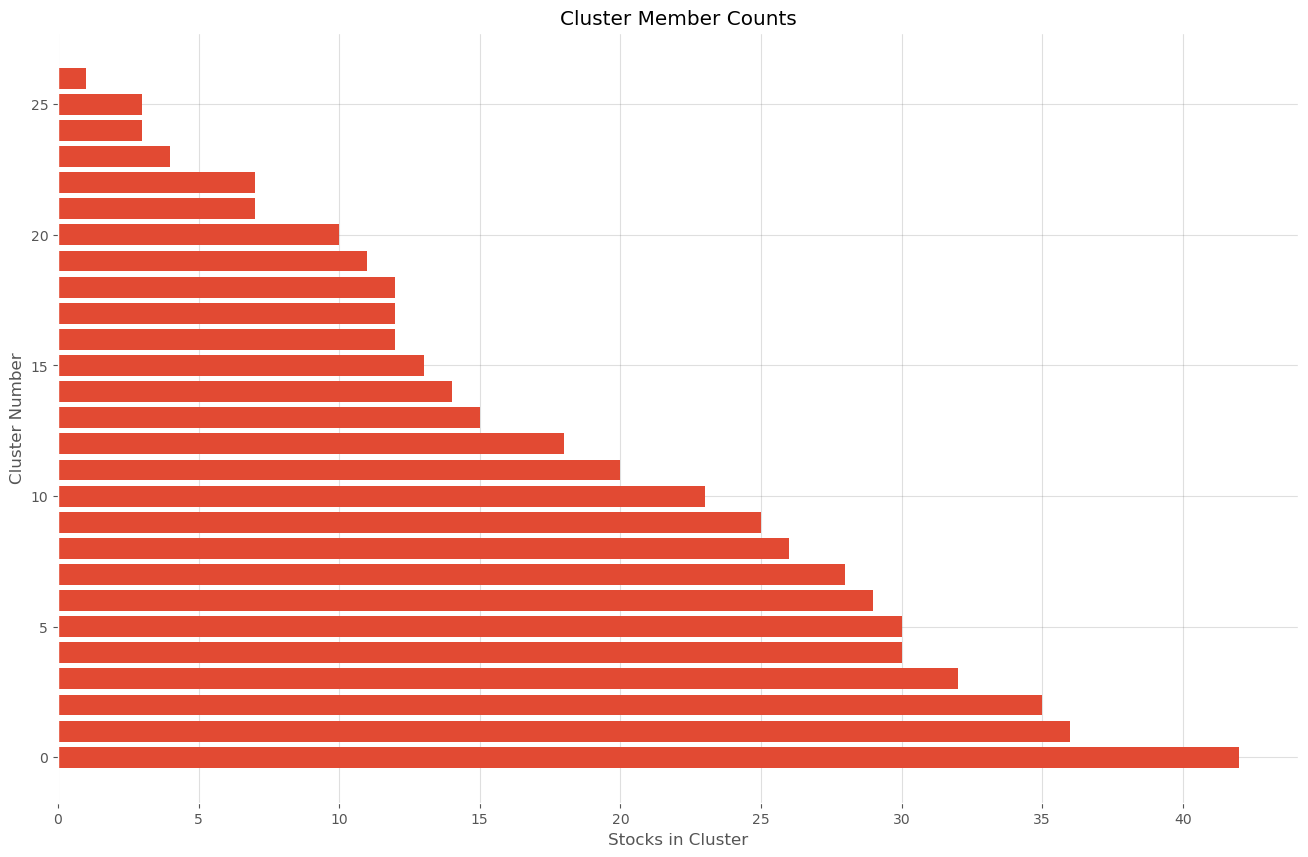

In [54]:
plt.figure(figsize=(16,10)
          )

plt.barh(
    range(len(clustered_series_ap.value_counts()
             )
         ), # cluster labels, y axis
    clustered_series_ap.value_counts()
)

plt.title("Cluster Member Counts")
plt.xlabel("Stocks in Cluster")
plt.ylabel("Cluster Number")

plt.show()

### Cluster Evaluation

> If the ground truth labels are not known, an evaluation must be performed using the model itself. 

> The Silhouette Coefficient (`sklearn.metrics.silhouette_score`) is an example of such an evaluation. 

> A higher Silhouette Coefficient score means a model with better defined clusters. 

> The Silhouette Coefficient is defined for each sample and is composed of two scores:

In [55]:
from sklearn import metrics

In [56]:
print("km", metrics.silhouette_score(X, k_means.labels_, 
                                     metric='euclidean')
     )

print("hc", metrics.silhouette_score(X, hc.fit_predict(X), 
                                     metric='euclidean')
     )

print("ap", metrics.silhouette_score(X, ap.labels_, 
                                     metric='euclidean')
     )

km 0.3358111045405199
hc 0.3432149515640864
ap 0.3450647315156526


> Let's go with `affinity propagation` here.

> We use 27 clusters, as specified by this clustering method.

### Visualising the return within a cluster

> To understand the intuition behind clustering, let us visualize the results of the clusters.

In [57]:
# All stock with its cluster label (including -1)
clustered_series = pd.Series(index = X.index, data = ap.fit_predict(X).flatten()
                            )

# Clustered stock with its cluster label

clustered_series_all = pd.Series(index = X.index, data = ap.fit_predict(X).flatten()
                                )

clustered_series = clustered_series[clustered_series != -1]

In [58]:
# Get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# Let's visualize some clusters
cluster_vis_list = list(counts[(counts < 25) & (counts > 1)].index)[::-1]
cluster_vis_list

[25, 11, 16, 20, 15, 2, 0, 19, 17, 5, 22, 21, 24, 10, 9, 13]

In [59]:
CLUSTER_SIZE_LIMIT = 9999

counts = clustered_series.value_counts()

ticker_count_reduced = counts[(counts>1) & (counts <= CLUSTER_SIZE_LIMIT)]

print ("Clusters formed: %d" % len(ticker_count_reduced)
      )
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)
                                 ).sum()
      )

Clusters formed: 26
Pairs to evaluate: 12166


In [60]:
# plot a handful of the smallest clusters
plt.figure(figsize=(16,10)
          )
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[25, 11, 16, 20]

<Figure size 1600x1000 with 0 Axes>

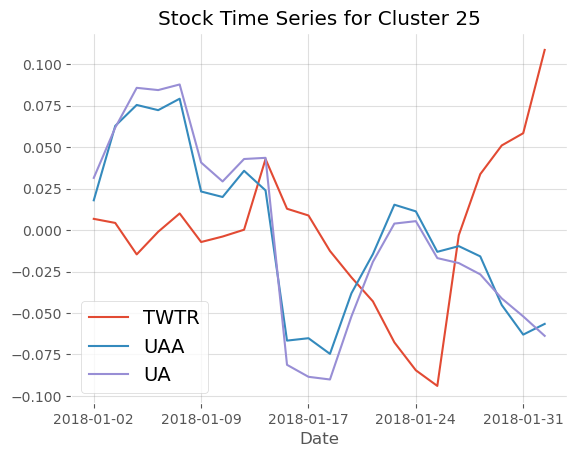

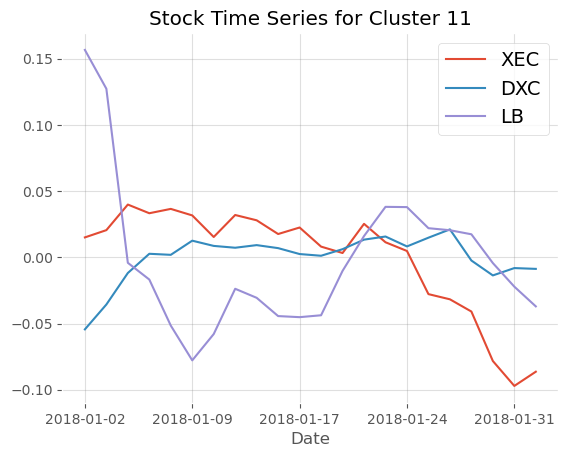

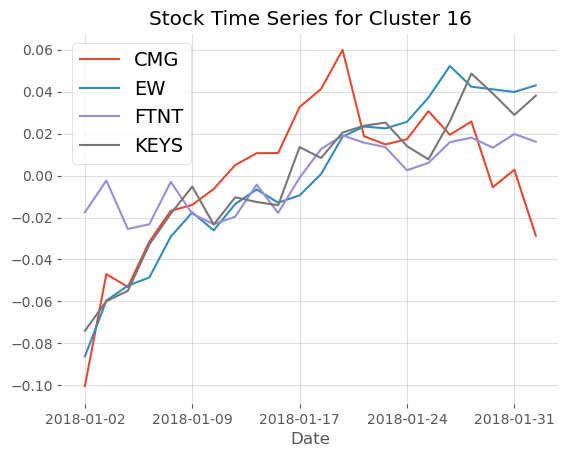

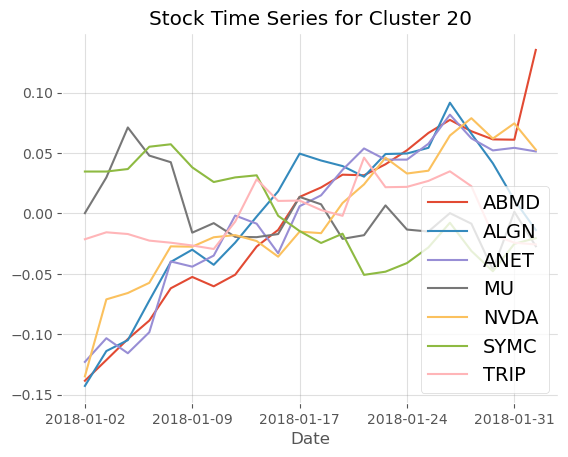

In [61]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    
    tickers = list(clustered_series[clustered_series == clust].index)
    
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    
    data = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    
    data.plot(title='Stock Time Series for Cluster %d' % clust)
    
plt.show()

> Looking at the charts above, in all the clusters with a small number of stocks, we see similar movement of the stocks. 
> This corroborates the effectiveness of the clustering technique.

## `Pairs Selection`

> Cointegration and Pair Selection Function

### `Cointegration` vs. Correlation

>  ***Correlation***

Correlation measures the linear relationship between two variables. The Pearson correlation coefficient between two variables \( X \) and \( Y \) is defined as:

$$
\rho_{X,Y} = \frac{\text{cov}(X, Y)}{\sigma_X \sigma_Y}
$$

Where:
- \( \text{cov}(X, Y) \) is the covariance between \( X \) and \( Y \).
- \( \sigma_X \) and \( \sigma_Y \) are the standard deviations of \( X \) and \( Y \) respectively.

> ***Cointegration***

Cointegration deals with the relationship between non-stationary time series. Two time series \( X_t \) and \( Y_t \) are said to be cointegrated if:

1. Both \( X_t \) and \( Y_t \) are non-stationary (typically, they have a unit root).
2. A linear combination exists such that \( Z_t = aX_t + bY_t \) is stationary.

If \( X_t \) and \( Y_t \) are cointegrated, there exists coefficients \( a \) and \( b \) (where \( b \neq 0 \)) such that the time series \( Z_t \) is stationary.

### Why Use Cointegration in Pairs Trading?

In pairs trading, the goal is to exploit deviations from a long-term equilibrium between two securities. While correlation can indicate a linear relationship, it doesn't ensure that the relationship is stable over time.

Cointegration, on the other hand, implies a long-term equilibrium relationship. If two securities are cointegrated, it means that even if they drift apart in the short term, they will revert back to a long-term equilibrium. This reversion is the essence of pairs trading.

All in all:
- **Correlation**: Measures the strength and direction of linear relationships.
- **Cointegration**: Focuses on the long-term equilibrium relationship between time series, which is crucial for pairs trading strategies.

Using cointegration in pairs trading provides more assurance of the existence of a stable, long-term relationship between the paired securities, which is the foundation of the strategy.


In [62]:
def find_cointegrated_pairs(data, significance=0.05):
    # Get the number of columns in the data (i.e., number of securities)
    n = data.shape[1]
    
    # Initialize a matrix filled with zeros to store cointegration scores
    score_matrix = np.zeros((n, n))
    
    # Initialize a matrix filled with ones to store p-values of the cointegration tests
    pvalue_matrix = np.ones((n, n))
    
    # Extract the column names (security names) from the data
    keys = data.keys()
    
    # List to store pairs of securities that are cointegrated
    pairs = []
    
    # Double loop to go through each combination of securities
    for i in range(n):  
        for j in range(i+1, n):
            
            # Extract the time series data for the two securities in consideration
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            
            # Perform the cointegration test between the two securities
            result = coint(S1, S2)
            
            # Extract the score (test statistic) and p-value from the result
            score = result[0]
            pvalue = result[1]
            
            # Store the score and p-value in their respective matrices
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            
            # If the p-value is less than the significance level, 
            # then the pair is considered cointegrated and added to the pairs list
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))

    # Return the score matrix, p-value matrix, and the list of cointegrated pairs
    return score_matrix, pvalue_matrix, pairs

In [63]:
from statsmodels.tsa.stattools import coint

In [ ]:
cluster_dict = {}

for i, which_clust in enumerate(ticker_count_reduced.index):
    
    tickers = clustered_series[clustered_series == which_clust].index   
    
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(dataset[tickers]
                                   )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]["score_matrix"] = score_matrix
    cluster_dict[which_clust]["pvalue_matrix"] = pvalue_matrix
    cluster_dict[which_clust]["pairs"] = pairs

In [ ]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]["pairs"])

In [ ]:
print ("Number of pairs found : %d" % len(pairs)
      )
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)
                                                           )
      )

In [ ]:
pairs

### What We Learned

> Clustering techniques do not directly help in stock trend prediction. However, they can be used in portfolio construction to find the right pairs. This eventually helps in risk mitigation, and one can achieve superior risk-adjusted returns.

> We have looked at methods of finding the appropriate number of clusters in k-means, and have built a hierarchy graph in hierarchical clustering. A next step in this case study would be to explore and backtest various long/short trading strategies with pairs of stocks from the groupings of stocks.

> Clustering can be used to divide stocks into groups with`similar characteristics` for many other kinds of trading strategies. It can also help in portfolio construction, to ensure we select stocks with sufficient diversification between them.

> `Thank you for working with the script, Team 👍`